# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
import xgboost as xgb

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [2]:
# Define some useful functions

def dummify(df, column):
    temp_list = list(df[column])
    temp_df = pd.DataFrame(temp_list, columns = [column])
    dummy_df = pd.get_dummies(temp_df, columns = [column], prefix = ['type_is'])
    return dummy_df

def binary_classifier_metrics(y_test, y_pred):
    
    """
    Quick function to return metrics for binary classification models.
    
    Requires the imports of the functions below.
    """
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    print('Precision score: ', precision_score(y_test, y_pred))
    print('Recall score: ', recall_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    
def regression_metrics(y_test, y_pred):
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('Mean Absolute Error: ', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
    
    
def grid_search_results(grid_search, X, y):
    """
    Returns grid search results in a readable format
    """
    
    print('Best Score: ',grid_search.score(X, y, ))
    print('Best Params: ', grid_search.best_params_)

In [3]:
def grid_search_results(grid_search, X, y):
    print('Best Score: ',grid_search.score(X, y, ))
    print('Best Params: ', grid_search.best_params_)

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [4]:
data = pd.read_csv('data/clean_df.csv')

In [5]:
data.head()

,Unnamed: 0,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,crs_arr_time,arr_delay,cancelled,...,haul_type,route,carrier_on_time_pct,plane_on_time_pct,origin_on_time_pct,fl_num_on_time_pct,route_on_time_pct,carrier_fuel_consumption,mean_taxi_out,mean_taxi_in
0,0,AA,5606,N575NN,MYR,CLT,2157,2311,-3.0,0.0,...,Short,MYR_CLT,0.738134,0.698113,0.832627,0.693182,0.815657,6.758333e-08,14.188559,9.765890
1,2,AA,5607,N254PS,DCA,BDL,1009,1126,14.0,0.0,...,Short,DCA_BDL,0.738134,0.707224,0.788449,0.688889,0.712934,6.758333e-08,18.247400,7.549458
2,3,AA,5608,N710PS,DCA,GSP,2000,2134,-12.0,0.0,...,Short,DCA_GSP,0.738134,0.697279,0.788449,0.724409,0.675439,6.758333e-08,18.247400,7.549458
3,4,AA,5610,N515AE,ORF,CLT,1215,1347,-14.0,0.0,...,Short,ORF_CLT,0.738134,0.777090,0.786831,0.737288,0.834515,6.758333e-08,15.585689,8.718280
4,5,AA,5613,N242JS,DCA,CLE,2220,2343,7.0,0.0,...,Short,DCA_CLE,0.738134,0.750000,0.788449,0.684932,0.843750,6.758333e-08,18.247400,7.549458


In [6]:
data.shape

(1079053, 46)

In [7]:

# Separate the target feature

target = data['arr_delay']
data = data.drop(columns = 'arr_delay')

In [9]:
data = data.drop(columns = ['Unnamed: 0', 'dest', 'origin',
                           'route',
                            'arr_period',
                            'dep_period',
                            'mkt_unique_carrier',
                            'mkt_carrier_fl_num',
                            'tail_num',
                            'dep_state',
                           'dest_state',
                           'crs_dep_time',
                           'crs_arr_time',
                            'carrier_delay',
                           'weather_delay',
                           'nas_delay',
                           'security_delay',
                           'late_aircraft_delay',
                           'dest_match_code',
                           'origin_match_code',
                           'crs_dep_minutes',
                           'crs_arr_minutes',
                           'year', 'month', 'day',
                           'on_time',
                            'mkt_carrier_fl_num',
                            'haul_type',
                             'cancelled',
                           'cancellation_code'
                           ])

In [10]:
data.shape

(1079053, 16)

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.



In [11]:
# Check the data types of the columns
data.dtypes

distance                    float64
origin_weather_condition     object
origin_weather_severity      object
dest_weather_condition       object
dest_weather_severity        object
week_day                     object
crs_dep_hour                  int64
crs_arr_hour                  int64
carrier_on_time_pct         float64
plane_on_time_pct           float64
origin_on_time_pct          float64
fl_num_on_time_pct          float64
route_on_time_pct           float64
carrier_fuel_consumption    float64
mean_taxi_out               float64
mean_taxi_in                float64
dtype: object

In [13]:
# Get lists of numeric columns and object columns to facilitate making dummy variables and scaling

numeric_cols = ['distance',
               'crs_dep_hour',
               'crs_arr_hour',
               'carrier_on_time_pct',
               'plane_on_time_pct',
               'fl_num_on_time_pct',
               'origin_on_time_pct',
               'route_on_time_pct',
               'mean_taxi_out', 
               'carrier_fuel_consumption',
               'mean_taxi_in']
obj_cols = data.drop(columns = numeric_cols).columns.to_list()
# obj_cols.pop()
obj_cols

['origin_weather_condition',
 'origin_weather_severity',
 'dest_weather_condition',
 'dest_weather_severity',
 'week_day']

In [14]:
# Create Dummy variables for the object columns

for col in obj_cols:
    temp_df = dummify(data, col)
    data = data.merge(temp_df, 
                               left_index = True, 
                               right_index = True)

In [15]:
# Drop object columns

data = data.drop(columns = obj_cols)
data.head()

,distance,crs_dep_hour,crs_arr_hour,carrier_on_time_pct,plane_on_time_pct,origin_on_time_pct,fl_num_on_time_pct,route_on_time_pct,carrier_fuel_consumption,mean_taxi_out,...,type_is_Light_y,type_is_Moderate_y,type_is_Severe_y,type_is_Friday,type_is_Monday,type_is_Saturday,type_is_Sunday,type_is_Thursday,type_is_Tuesday,type_is_Wednesday
0,157.0,21,23,0.738134,0.698113,0.832627,0.693182,0.815657,6.758333e-08,14.188559,...,1,0,0,0,0,0,0,0,1,0
1,313.0,10,11,0.738134,0.707224,0.788449,0.688889,0.712934,6.758333e-08,18.247400,...,0,1,0,0,0,0,0,0,1,0
2,396.0,20,21,0.738134,0.697279,0.788449,0.724409,0.675439,6.758333e-08,18.247400,...,1,0,0,0,0,0,0,0,1,0
3,290.0,12,13,0.738134,0.777090,0.786831,0.737288,0.834515,6.758333e-08,15.585689,...,1,0,0,0,0,0,0,0,1,0
4,310.0,22,23,0.738134,0.750000,0.788449,0.684932,0.843750,6.758333e-08,18.247400,...,1,0,0,0,0,0,0,0,1,0


In [16]:
data.shape

(1079053, 28)

In [17]:
# Apply scaling to the numeric columns
scaler = StandardScaler()
numerics_scaled = scaler.fit_transform(data[numeric_cols], target)

In [18]:
# Rename columns from scaling back to their original names, merge with data

numeric_dict = {0: 'distance',
               1: 'crs_dep_hour',
               2: 'crs_arr_hour',
               3: 'carrier_on_time_pct',
               4: 'plane_on_time_pct',
               5: 'fl_num_on_time_pct',
               6: 'origin_on_time_pct',
               7: 'route_on_time_pct',
               8: 'origin_taxi_out',
               9: 'carrier_fuel_consumption',
               10: 'mean_taxi_in'}
numerics_scaled = pd.DataFrame(numerics_scaled).rename(columns = numeric_dict)
data = data.drop(columns = numeric_cols)
data = data.merge(numerics_scaled, left_index=True, right_index=True)


In [19]:
data.shape

(1079053, 28)

In [20]:
data.dtypes

type_is_Adverse_x             uint8
type_is_Clear_x               uint8
type_is_Light_x               uint8
type_is_Moderate_x            uint8
type_is_Severe_x              uint8
type_is_Adverse_y             uint8
type_is_Clear_y               uint8
type_is_Light_y               uint8
type_is_Moderate_y            uint8
type_is_Severe_y              uint8
type_is_Friday                uint8
type_is_Monday                uint8
type_is_Saturday              uint8
type_is_Sunday                uint8
type_is_Thursday              uint8
type_is_Tuesday               uint8
type_is_Wednesday             uint8
distance                    float64
crs_dep_hour                float64
crs_arr_hour                float64
carrier_on_time_pct         float64
plane_on_time_pct           float64
fl_num_on_time_pct          float64
origin_on_time_pct          float64
route_on_time_pct           float64
origin_taxi_out             float64
carrier_fuel_consumption    float64
10                          

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?
- PCA vs LDA?
- Check for high correlation, low variance
- Try some wrapper methods

# Selection of Features for modeling

In [21]:

data_train = data

In [ ]:
# df_corr = data_train.corr()
# fig, ax = plt.subplots(figsize=(15, 12))
# sns.heatmap(df_corr, annot = False, cmap="YlGnBu")


# PCA

In [22]:
# Initialize pca with components = 2
n_components = data_train.shape[1]
pca = PCA(n_components = n_components)
components = pca.fit_transform(data_train)

In [23]:
# Calculate and print the total variance
total_variance = pca.explained_variance_ratio_.sum() * 100
total_variance

100.0

In [24]:
pca.explained_variance_ratio_ * 100

array([2.04649425e+01, 1.38214886e+01, 9.18646469e+00, 8.06891925e+00,
       7.26565948e+00, 7.07956424e+00, 6.14058032e+00, 5.76291620e+00,
       3.23585229e+00, 3.21500089e+00, 2.67387625e+00, 2.54582263e+00,
       2.25958736e+00, 1.31652895e+00, 1.23038655e+00, 1.12506142e+00,
       1.01061350e+00, 9.97636065e-01, 9.81000685e-01, 5.36673139e-01,
       5.10505040e-01, 2.96242794e-01, 2.74677202e-01, 9.04747514e-27,
       6.37057283e-27, 3.89500028e-27, 4.03810229e-30, 6.20211922e-34])

Text(0.5, 1.0, 'Scree plot for 25 Component PCA Analysis')

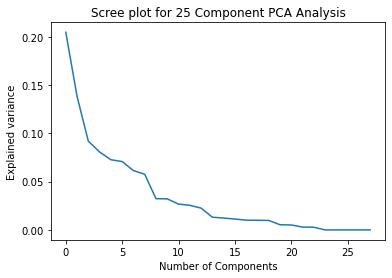

In [25]:
plt.plot(range(n_components), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained variance')
plt.title('Scree plot for 25 Component PCA Analysis')

In [28]:
# Reinitialize PCA with 5 components
n_components = 8
pca = PCA(n_components = n_components)
components = pca.fit_transform(data)

In [29]:
pca.explained_variance_ratio_ * 100

array([20.46494251, 13.82148856,  9.18646466,  8.0689192 ,  7.26565946,
        7.07956417,  6.14058023,  5.76291605])

# Clustering

In [ ]:
def plot_distortion(X,max_clusters = 15):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

In [ ]:
# plot_distortion(data_train, 10)

In [ ]:
# Initialize the kmeans object with 3 clusters
k_means = km = KMeans(n_clusters = 3,
           n_init = 10,
           random_state = 13)

In [ ]:
# Establish predicitons, assign the label to the dataset
y_km = km.fit_predict(data_train)
data_train['kmeans_label'] = y_km



In [ ]:
data_train

# Train Test Split

Do two train test splits.  One for the standard data and another for data that underwent PCA

In [30]:
X_train, X_val, y_train, y_val = train_test_split(data_train, target, test_size = 0.25, random_state = 13)

In [31]:
X_train_pca, X_val_pca, y_train_pca, y_val_pca  = train_test_split(components, target, test_size = 0.25)

In [ ]:
# X_train_poly, X_val_poly, y_train_poly, y_val_poly = train_test_split(X_poly, target, test_size = 0.25)

# Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

# Random Forest

In [ ]:
# rfr = RandomForestRegressor(n_estimators = 100,
#                             max_depth = 5)
# rfr.fit(X_train, y_train)


In [ ]:
# y_pred_rfr = rfr.predict(X_val)

In [ ]:
# regression_metrics(y_val, y_pred_rfr)

# Linear Regression


Baseline r2 = 0.0477 <br>
PCA 20 component r2 = 0.383

In [32]:
# Linear regression on raw data
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred_l_reg = l_reg.predict(X_val)

In [34]:
l_reg.coef_

array([ 1.38462530e+08,  1.38462528e+08,  2.04477688e+10,  2.04477688e+10,
        2.04477688e+10, -7.61553461e+09, -7.61553461e+09,  2.97357267e+10,
        2.97357267e+10,  2.97357267e+10, -5.52930847e+10, -5.52930847e+10,
       -5.52930847e+10, -5.52930847e+10, -5.52930847e+10, -5.52930847e+10,
       -5.52930847e+10, -1.10630499e+00,  1.98056226e-01,  1.44799862e-01,
        3.02138681e-02, -1.50638178e+00, -1.16154762e+00, -3.48146945e-01,
       -2.40793453e+00, -7.28708910e-01, -1.58199732e-01, -4.99947359e-01])

In [35]:
regression_metrics(y_val, y_pred_l_reg)

R2 Score:  0.09674605119603319
Mean Absolute Error:  10.33510197826139
Mean Squared Error:  179.697574564016


In [36]:
current_data = data_train.columns.to_list()

In [37]:
coef_dict = dict(zip(current_data, l_reg.coef_))
coef_df = pd.Series(coef_dict)
coef_df.sort_values()
                

type_is_Tuesday            -5.529308e+10
type_is_Sunday             -5.529308e+10
type_is_Saturday           -5.529308e+10
type_is_Wednesday          -5.529308e+10
type_is_Monday             -5.529308e+10
type_is_Thursday           -5.529308e+10
type_is_Friday             -5.529308e+10
type_is_Clear_y            -7.615535e+09
type_is_Adverse_y          -7.615535e+09
route_on_time_pct          -2.407935e+00
plane_on_time_pct          -1.506382e+00
fl_num_on_time_pct         -1.161548e+00
distance                   -1.106305e+00
origin_taxi_out            -7.287089e-01
10                         -4.999474e-01
origin_on_time_pct         -3.481469e-01
carrier_fuel_consumption   -1.581997e-01
carrier_on_time_pct         3.021387e-02
crs_arr_hour                1.447999e-01
crs_dep_hour                1.980562e-01
type_is_Clear_x             1.384625e+08
type_is_Adverse_x           1.384625e+08
type_is_Moderate_x          2.044777e+10
type_is_Severe_x            2.044777e+10
type_is_Light_x 

# Ridge

First grid search --> Best alpha was 10
Second grid search --> Best alpha was 20

In [38]:
ridge = Ridge(alpha = 50)
ridge.fit(X_train, y_train)
ridge.coef_

array([ 1.15725715, -1.15725715,  0.62858691, -0.83280135,  0.20421444,
        1.73226529, -1.73226529,  0.94811007, -0.69309046, -0.25501961,
        0.93612218,  0.25040163, -0.33514722, -0.34663132,  0.57299283,
       -0.86789844, -0.20983966, -1.10623335,  0.19804317,  0.14479372,
        0.03006577, -1.50625114, -1.16151251, -0.34820974, -2.40774436,
       -0.7286518 , -0.15820375, -0.4999004 ])

In [39]:
ridge_predict = ridge.predict(X_val)

In [40]:
regression_metrics(y_val, ridge_predict)

R2 Score:  0.09674476339886451
Mean Absolute Error:  10.335100668698056
Mean Squared Error:  179.69783076442127


In [ ]:
params = {'alpha':[50, 75, 100, 150]
         }

In [ ]:
grid_ridge = GridSearchCV(estimator = ridge,
                       param_grid = params,
                       cv = 5)
y_grid_ridge = grid_ridge.fit(X_train, y_train)

In [ ]:
grid_search_results(grid_ridge, X_train, y_train)

# Lasso

In [41]:
lasso = Lasso(alpha = 0.0001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [42]:
lasso_predict = lasso.predict(X_val)

In [43]:
regression_metrics(y_val, lasso_predict)

R2 Score:  0.09674467520775953
Mean Absolute Error:  10.335098373495343
Mean Squared Error:  179.6978483095731


In [ ]:
params = {'alpha':[0.001,0.01, 0.1]
         }

grid_lasso = GridSearchCV(estimator = lasso,
                       param_grid = params,
                       cv = 5)
y_grid_lasso = grid_lasso.fit(X_train, y_train)

In [ ]:
grid_search_results(grid_lasso, X_train, y_train)

# Linear Regression on PCA Components

In [44]:
# Linear regression on components
l_reg_pca = LinearRegression()
l_reg_pca.fit(X_train_pca, y_train_pca)

LinearRegression()

In [45]:
y_pred_l_reg_pca = l_reg_pca.predict(X_val_pca)

In [46]:
regression_metrics(y_val_pca, y_pred_l_reg_pca)

R2 Score:  0.07577798038741368
Mean Absolute Error:  10.461720646366238
Mean Squared Error:  184.29289484412976


# XGBoost

In [47]:
xgb_r = xgb.XGBRegressor(objective = 'reg:squarederror',
                        n_estimators = 150,
                         max_depth = 15,
                         booster = 'gbtree',
                         seed = 13)

In [48]:
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=8, num_parallel_tree=1, random_state=13,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=13,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [49]:
y_xgb = xgb_r.predict(X_val)

In [50]:
regression_metrics(y_val, y_xgb)

R2 Score:  0.13600050971830524
Mean Absolute Error:  10.093239406002667
Mean Squared Error:  171.88810858092626


In [ ]:
params = {'n_estimators': [50, 100, 150],
          'max_depth': [5, 10],
          'booster': ['gbtree', 'gblinear']
         }

In [ ]:
grix_xgb = GridSearchCV(estimator = xgb_r,
                       param_grid = params,
                       cv = 5)

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.